## 4.0. Figure 3 - kNN classifier on test set discarding non-informative signals

Using replicate 3 (numbered from 1) and assess how accuracy changes when discarding signals with neighbors shared among classes.

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
import matplotlib.ticker as mtick

from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_fscore_support as score

import sys 
sys.path.append('..')
from src.constants import SAMPLES_DICT_3CLASS
from src.knn_load_data import (
    INDICES_SAVE_PATH_3CLASS, DTW_SAVE_PATH_3CLASS,
    load_data, prefix_data_dir, load_np_data
)
# from src.utils_data import load_data, load_np_data, split_dtw_train_val_test
# MOD removed the one on top to keep the one below only.. 
# from src.utils_data_notorchmarc import load_data, load_np_data, split_dtw_train_val_test
from src.knn_classifier import (
    train_test_dtw_knn_single_sample, knn_classifier_ontest,
    plot_roc_curve, accuracy_bysignumb_fixneigh, accuracy_bysignumb_randomthld,
    best_neighbors_value, 
)

In [2]:
SAMPLES_DICT_3CLASS = prefix_data_dir(SAMPLES_DICT_3CLASS, "/mmfs1/gscratch/ml4ml/cailinw/pore_data/")

## Prepare data

### Subsetting sample 2 only

In [3]:
data, labels_ori, samples_ori, indices_ori, labels_key = load_data(
    samples_dict=SAMPLES_DICT_3CLASS,
    save_dir=INDICES_SAVE_PATH_3CLASS,
    load_raw_signals=False
)

dtw_mat_ori = load_np_data(f"{DTW_SAVE_PATH_3CLASS}nonorm_nosmooth_100_nopad_3class.npy")
num_classes = 3
num_samples = 1

class_names=['heart', 'adrenal', 'aorta']
num_classes=3
num_samples=[4, 4, 4]
In progress...
 
 lass heart, replicate 4/4
 lass adrenal, replicate 4/4


In [4]:
chosen_sample = 2

In [5]:
sample_selector = (samples_ori == chosen_sample)

In [6]:
labels = labels_ori[sample_selector]

In [7]:
samples = samples_ori[sample_selector]

In [8]:
indices = indices_ori[sample_selector]

In [9]:
dtw_mat = dtw_mat_ori[np.ix_(sample_selector,sample_selector)]

In [10]:
print(dtw_mat.shape)
print(samples.shape)

(9840, 9840)
(9840,)


In [11]:
labels_key

{0: 'heart', 1: 'adrenal', 2: 'aorta'}

In [12]:
pd.Series(labels).value_counts()

0    3280
1    3280
2    3280
dtype: int64

In [13]:
pd.Series(samples).value_counts()

2    9840
dtype: int64

In [14]:
labels

array([0, 0, 0, ..., 2, 2, 2])

In [15]:
samples

array([2, 2, 2, ..., 2, 2, 2])

### Randomly shuffling labels

In [16]:
pd.Series(labels).value_counts()

0    3280
1    3280
2    3280
dtype: int64

In [17]:
labels

array([0, 0, 0, ..., 2, 2, 2])

In [18]:
rand_labels = labels.copy()
np.random.seed(42)
# shuffles in place
np.random.shuffle(rand_labels)

We can see counts haven't changed but its order has.

In [19]:
pd.Series(rand_labels).value_counts()

2    3280
0    3280
1    3280
dtype: int64

In [20]:
# labels have not changed
labels

array([0, 0, 0, ..., 2, 2, 2])

In [21]:
# but just created a bunch of random labels
rand_labels

array([2, 2, 0, ..., 1, 0, 2])

## Split 70% for training and 30% for testing

Use Sklearn's train_test_split, and stratify by label to have balanced classes and generate the splits

To slice the objects, I create an array of 1 to #signals, which will be split in two. Do not confuse this with the signal index which identifies every signal that is also obtained below

In [22]:
select_idx = np.arange(len(labels))

Generate a different split for each random method to keep the labels balanced in all of them

In [23]:
X_train = {}
y_train = {}
X_test = {}
y_test = {}
signal_index_train = {}
signal_index_test = {}

In [24]:
seed = 42

Example

In [25]:
for method, lbl in zip(['real','rand'], [labels, rand_labels]):
    train_index, test_index, train_labl, test_labl = train_test_split(select_idx, lbl,
                                                        stratify=lbl, shuffle=True,
                                                        # adjusted this value to get a value in training divisible by 10
                                                        test_size=0.2987, random_state=seed)
    print(test_index)

[1899 4371  980 ... 6524 9286 8209]
[5602 3213 2889 ... 9729 8183 5108]


Now with the data

In [26]:
for method, lbl in zip(['real','rand'], [labels, rand_labels]):
    train_index, test_index, train_labl, test_labl = train_test_split(select_idx, lbl,
                                                        stratify=lbl, shuffle=True,
                                                        # adjusted this value to get a value in training divisible by 10
                                                        test_size=0.2987, random_state=seed)
    print('For:', method)
    print(pd.Series(train_labl).value_counts())
    print('Train size:', len(train_index), ' Test size:', len(test_index))
    X_train[method] = dtw_mat[np.ix_(train_index, train_index)]
    X_test[method] = dtw_mat[np.ix_(test_index, train_index)]
    y_train[method] = lbl[train_index]
    signal_index_train[method] = indices[train_index]
    y_test[method] = lbl[test_index]
    signal_index_test[method] = indices[test_index]

For: real
2    2300
1    2300
0    2300
dtype: int64
Train size: 6900  Test size: 2940
For: rand
2    2300
1    2300
0    2300
dtype: int64
Train size: 6900  Test size: 2940


### Use training to find an appropiate number of neighbors

In [27]:
# containers for the data
accuracy = {}
auc_score = {}
accuracy_mean = {}
auc_score_mean = {}
accuracy_sd = {}
auc_score_sd = {}
probs_info = {}

In [28]:
# must be exact divident of training size
num_splits = 10

In [29]:
# Tune these parameters, here only testing uniform
k_neighbors_options = np.arange(3,800, 4)
knn_weights_options=['uniform','distance']
knn_weights = 'uniform'

In [30]:
# when probabilities are equal, decision is made randomly. Set seed for reproducibility
np.random.seed(42)
for method in ['real','rand']:
    results = train_test_dtw_knn_single_sample(
        X_train[method], y_train[method], num_classes, num_splits,
        k_neighbors_options, knn_weights, report_add_info=True
    )
    accuracy[method] = results[0]
    auc_score[method] = results[1]
    accuracy_mean[method] = results[2]
    auc_score_mean[method] = results[3]
    accuracy_sd[method] = results[4]
    auc_score_sd[method] = results[5]
    probs_info[method] = results[6]

10 690 (10, 690)
Now evaluating with split 1/10
Now evaluating with split 2/10
Now evaluating with split 3/10
Now evaluating with split 4/10
Now evaluating with split 5/10
Now evaluating with split 6/10
Now evaluating with split 7/10
Now evaluating with split 8/10
Now evaluating with split 9/10
Now evaluating with split 10/10
10 690 (10, 690)
Now evaluating with split 1/10
Now evaluating with split 2/10
Now evaluating with split 3/10
Now evaluating with split 4/10
Now evaluating with split 5/10
Now evaluating with split 6/10
Now evaluating with split 7/10
Now evaluating with split 8/10
Now evaluating with split 9/10
Now evaluating with split 10/10


### Best results on training set

In [31]:
for method in ['real','rand']:
    print(f'Data {method}:')
    print(f' Max training accuracy: {round(np.max(accuracy_mean[method]),4)}\n  with Neighbors: {k_neighbors_options[np.argmax(accuracy_mean[method])]}')
    print(f' Max training AUC: {round(np.max(auc_score_mean[method]),4)}\n  with Neighbors: {k_neighbors_options[np.argmax(auc_score_mean[method])]}')

Data real:
 Max training accuracy: 0.5142
  with Neighbors: 59
 Max training AUC: 0.6923
  with Neighbors: 59
Data rand:
 Max training accuracy: 0.34
  with Neighbors: 111
 Max training AUC: 0.5045
  with Neighbors: 75


### Training figure

In [32]:
method = 'real'
best_accuracy, best_auc_score = best_neighbors_value(accuracy_mean[method],auc_score_mean[method])

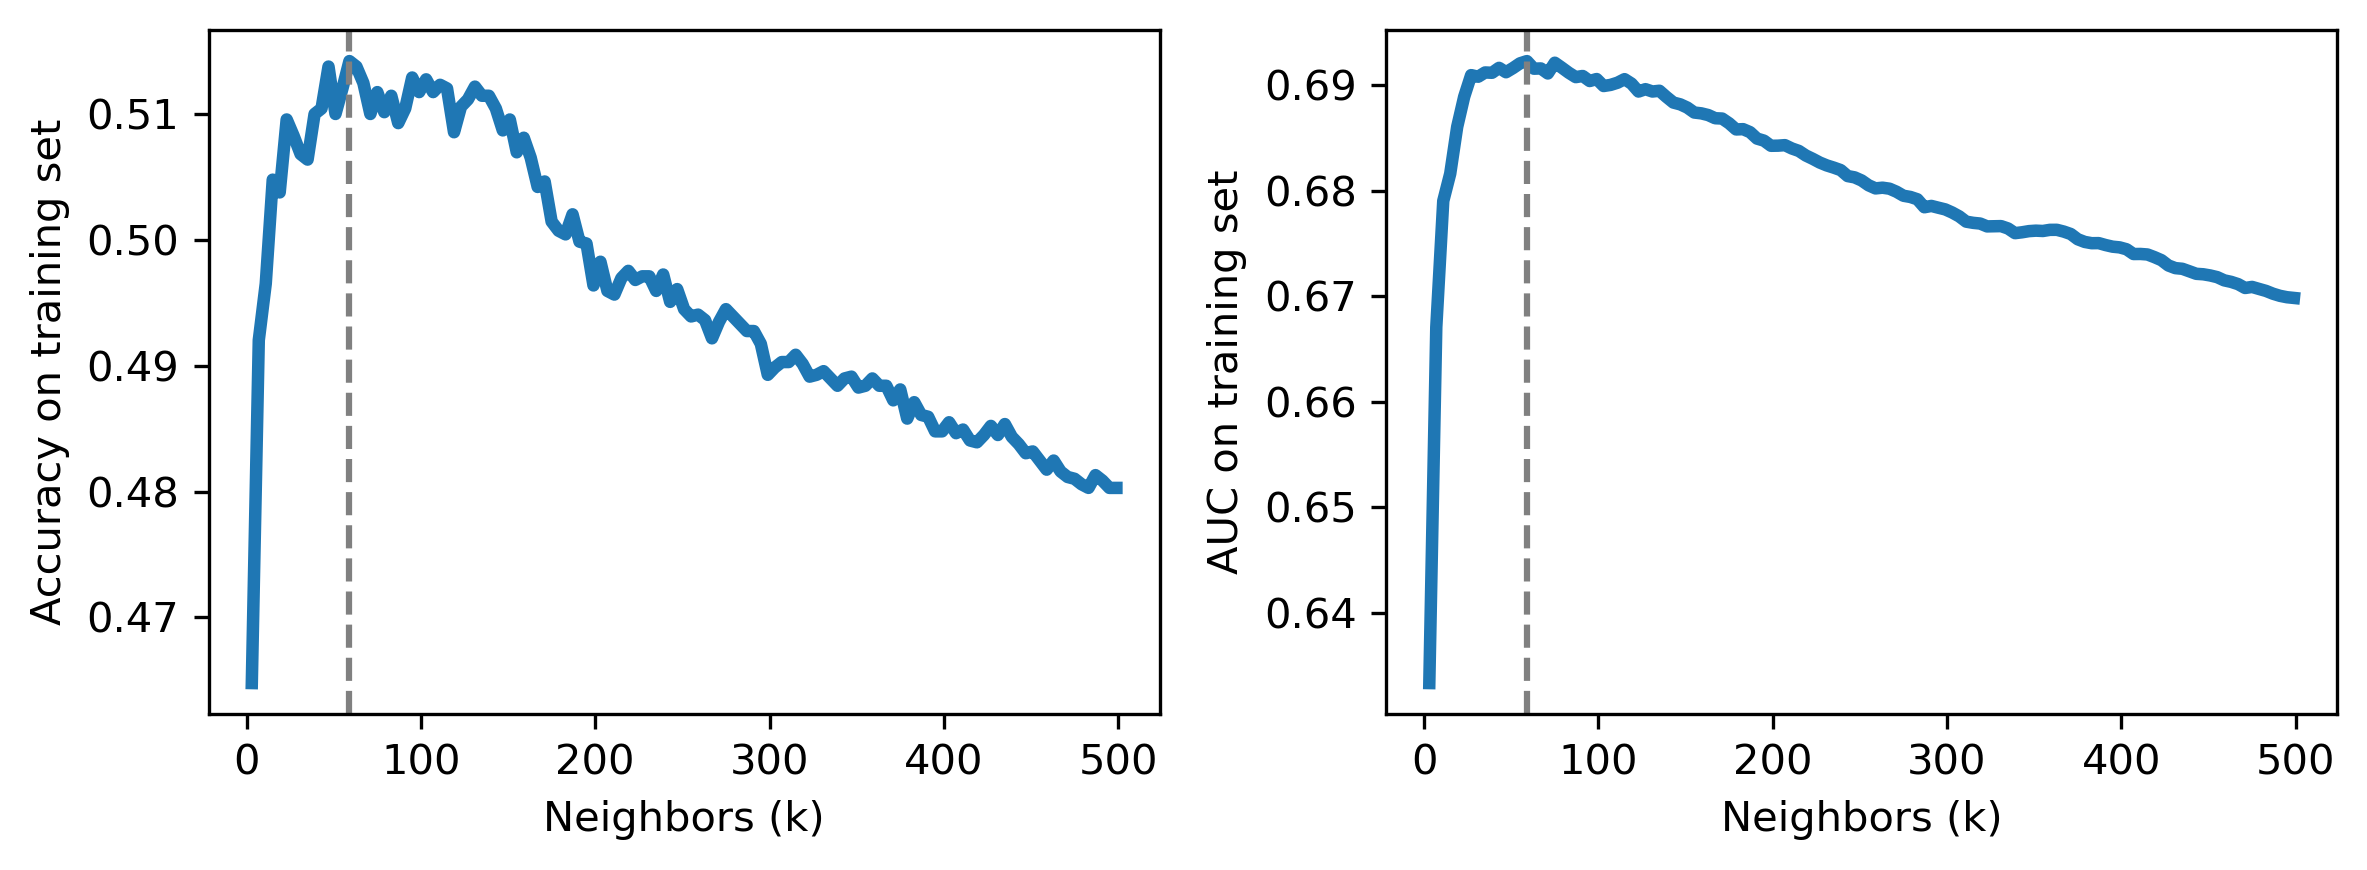

In [33]:
neighbor_limit = 125

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8,3), dpi=300)

ax1.plot(k_neighbors_options[:neighbor_limit], accuracy_mean['real'][:neighbor_limit], linewidth=3, label ='mean', color='tab:blue')
#     ax1.errorbar(k_neighbors_options[::50], accuracy_mean[::50], yerr=accuracy_sd[::50], fmt="none", color='silver')

ax1.set_ylabel('Accuracy on training set')
ax1.set_xlabel('Neighbors (k)')
ax1.axvline(x=k_neighbors_options[best_accuracy], ls="--", color='gray', label="k=59")
ax1.set_xscale('linear')

ax2.plot(k_neighbors_options[:neighbor_limit], auc_score_mean['real'][:neighbor_limit], linewidth=3, label ='mean', color='tab:blue')
#     ax2.errorbar(k_neighbors_options[::50], auc_score_mean[::50], yerr=auc_score_sd[::50], fmt="none", color='silver')

ax2.set_ylabel('AUC on training set')
ax2.set_xlabel('Neighbors (k)')
ax2.set_xscale('linear')
ax2.axvline(x=k_neighbors_options[best_accuracy], ls="--", color='gray', label="k=59")
# ax2.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()
plt.savefig('../figs/knn3.kNNtrain_curve.png',dpi=300, bbox_inches='tight')
plt.show()

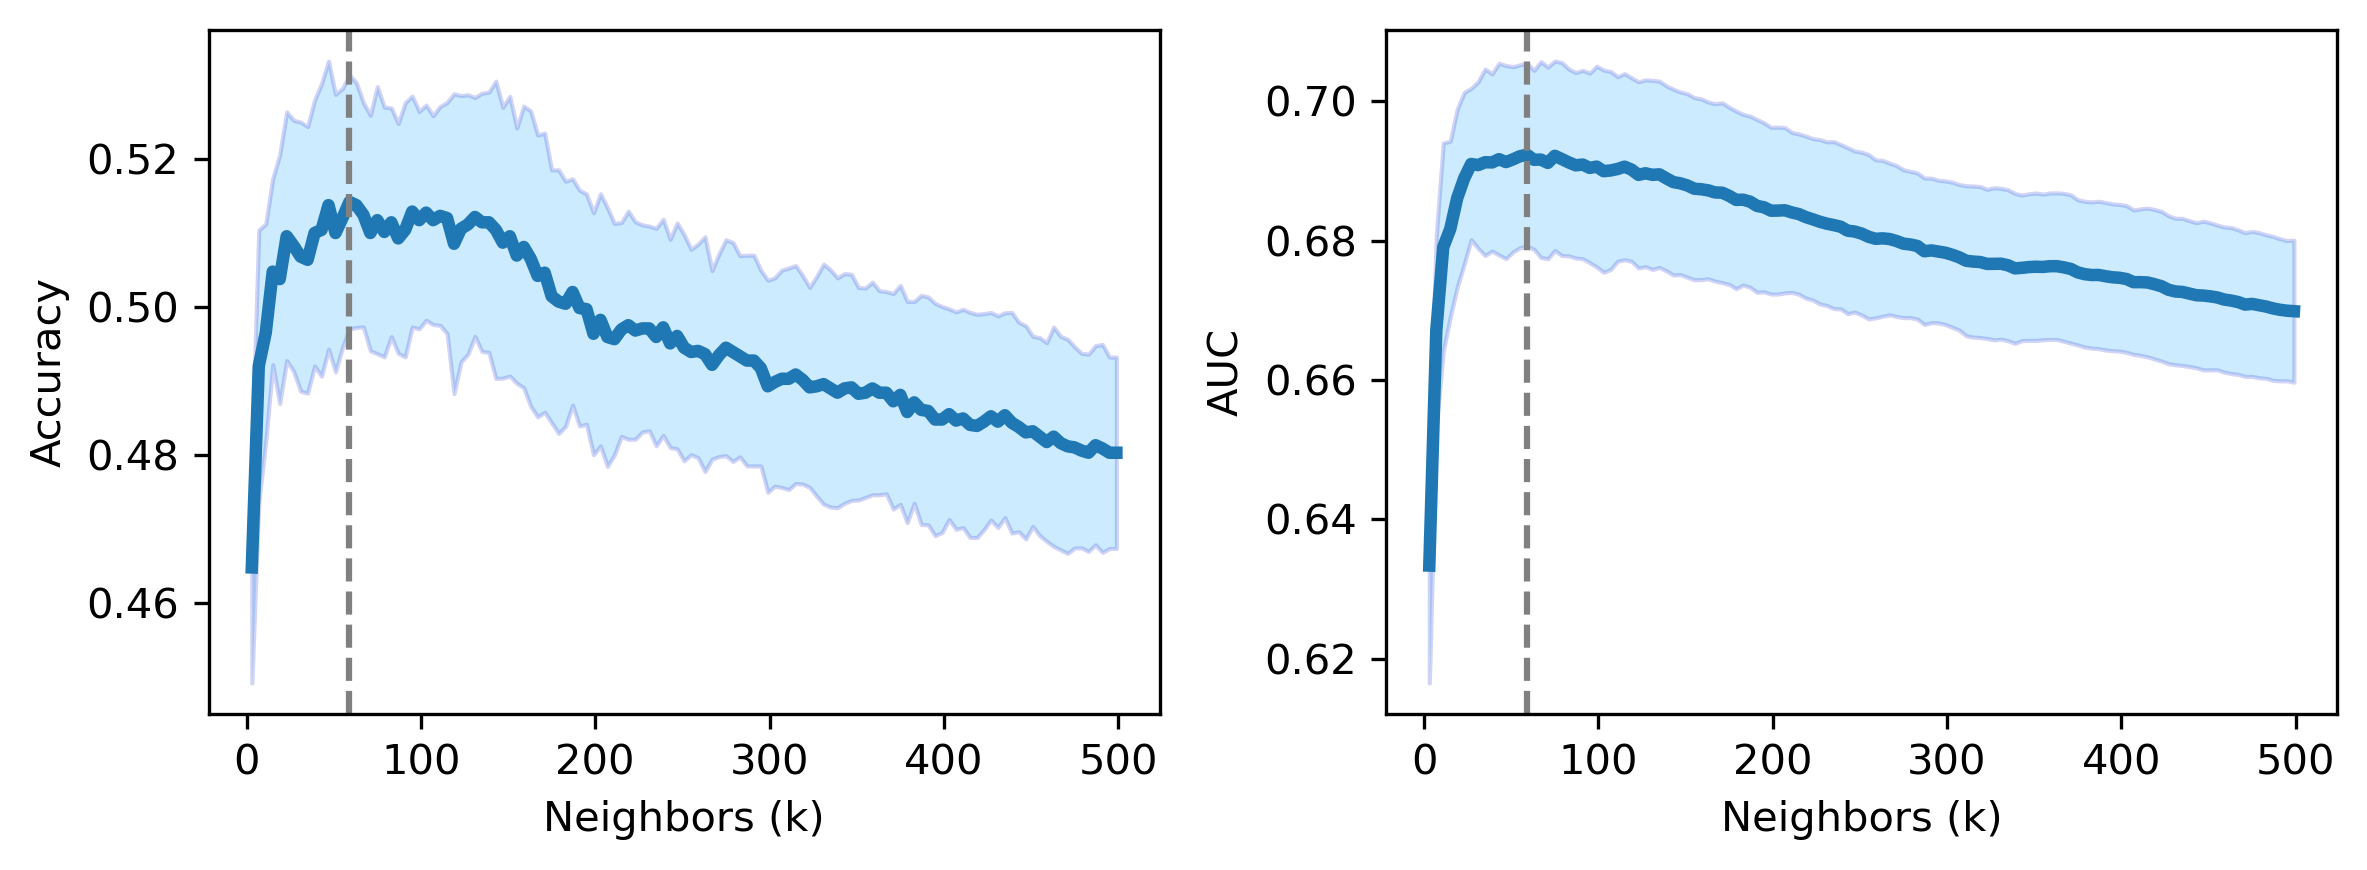

In [34]:
neighbor_limit = 125

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8,3), dpi=300)

ax1.plot(k_neighbors_options[:neighbor_limit], accuracy_mean['real'][:neighbor_limit], linewidth=3, label ='mean', color='tab:blue')

ax1.set_ylabel('Accuracy')
ax1.set_xlabel('Neighbors (k)')
ax1.axvline(x=k_neighbors_options[best_accuracy], ls="--", color='gray', label="k=59")
y = accuracy_mean['real'][:neighbor_limit]
error = accuracy_sd['real'][:neighbor_limit]
ax1.fill_between(k_neighbors_options[:neighbor_limit], y-error, y+error,
    alpha=0.2, edgecolor='#1B2ACC', facecolor='#089FFF',
    linewidth=1, ls='-', antialiased=True)
ax1.set_xscale('linear')

ax2.plot(k_neighbors_options[:neighbor_limit], auc_score_mean['real'][:neighbor_limit], linewidth=3, label ='mean', color='tab:blue')
ax2.set_ylabel('AUC')
ax2.set_xlabel('Neighbors (k)')
ax2.set_xscale('linear')
ax2.axvline(x=k_neighbors_options[best_accuracy], ls="--", color='gray', label="k=59")

y = auc_score_mean['real'][:neighbor_limit]
error = auc_score_sd['real'][:neighbor_limit]
ax2.fill_between(k_neighbors_options[:neighbor_limit], y-error, y+error,
    alpha=0.2, edgecolor='#1B2ACC', facecolor='#089FFF',
    linewidth=1, ls='-', antialiased=True)
plt.tight_layout()
plt.show()

Visualize accuracy per class depending on number of neighbors

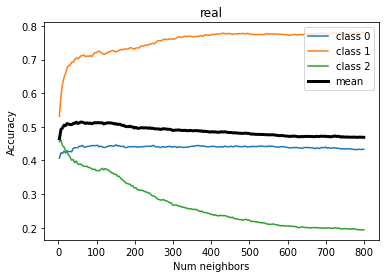

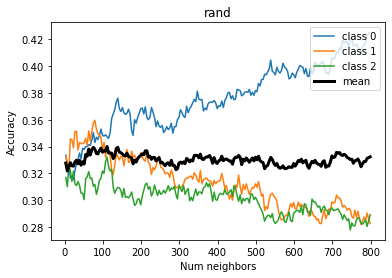

In [35]:
for method in ['real','rand']:
    accuracy_per_class = np.mean(probs_info[method]["accuracy_per_class"], axis=0)
    for cl in range(num_classes):
        plt.plot(k_neighbors_options, accuracy_per_class[cl], label = 'class '+str(cl))
    plt.plot(k_neighbors_options, np.mean(accuracy_per_class, axis=0), linewidth=3, label ='mean', color='k')
    plt.xlabel('Num neighbors')
    plt.ylabel('Accuracy')
    plt.legend(loc='upper right')
    plt.title(method)
    plt.show()

Other metrics

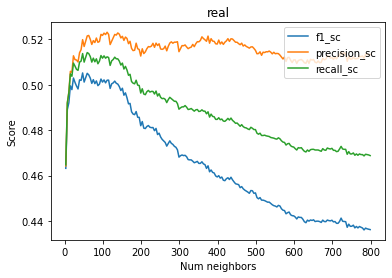

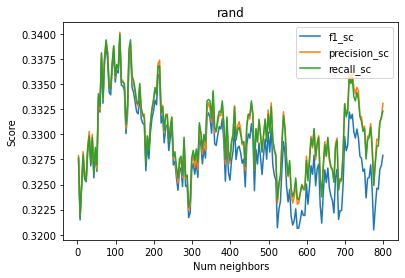

In [36]:
for method in ['real','rand']:
    accuracy_per_class = np.mean(probs_info[method]["accuracy_per_class"], axis=0)
    for sc in ["f1_sc", "precision_sc", "recall_sc"]:
        plt.plot(k_neighbors_options, np.mean(probs_info[method][sc],axis=0), label = sc)
    # plt.plot(k_neighbors_options, np.mean(accuracy_per_class, axis=0), linewidth=3, label ='Accuracy', color='k')
    plt.xlabel('Num neighbors')
    plt.ylabel('Score')
    plt.legend(loc='upper right')
    plt.title(method)
    plt.show()

## Defining k and getting test values

Chose k=59 because offers best accuracy and AUC on training data

In [37]:
k_neighbors = 59

Now train the classifier on the test data with this selected number of neighbors

In [38]:
probs_record = {}
metrics_record = {}
for method in ['real','rand']:
    probs_record[method], metrics_record[method] = knn_classifier_ontest(
        X_train[method],
        y_train[method],
        X_test[method],
        y_test[method],
        k_neighbors,
        num_classes,
        knn_weights
    )

Accuracy for each class

In [39]:
for method in ['real','rand']:
    print('Method', method)
    pred_class = probs_record[method]["pred_class"]
    true_class = probs_record[method]["true_class"]
    for cl in range(num_classes):
        
        print("  Class", cl, "accuracy="+str(round(np.mean([pred_class[true_class == cl] == true_class[true_class == cl]]),3)))

Method real
  Class 0 accuracy=0.457
  Class 1 accuracy=0.71
  Class 2 accuracy=0.396
Method rand
  Class 0 accuracy=0.328
  Class 1 accuracy=0.358
  Class 2 accuracy=0.312


Additional information

In [40]:
pd.set_option('precision', 2)

for method in ['real','rand']:
    print('Method', method)
    df_result = pd.DataFrame({'Class': [0,1,2],
                  'precision':metrics_record[method]["precision"],
                  'recall':metrics_record[method]["recall"],
                  'fscore':metrics_record[method]["fscore"],
                  'support':metrics_record[method]["support"]})
    print(df_result)

Method real
   Class  precision  recall  fscore  support
0      0       0.52    0.46    0.49      980
1      1       0.50    0.71    0.59      980
2      2       0.56    0.40    0.46      980
Method rand
   Class  precision  recall  fscore  support
0      0       0.33    0.33    0.33      980
1      1       0.34    0.36    0.35      980
2      2       0.33    0.31    0.32      980


### Roc curve

only needed `one_hot_y_test, probs_memory`

Method real


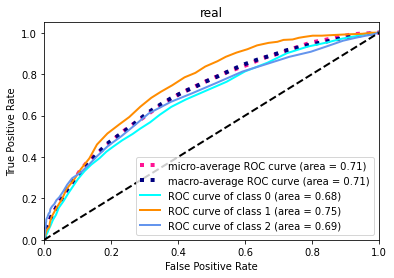

Method rand


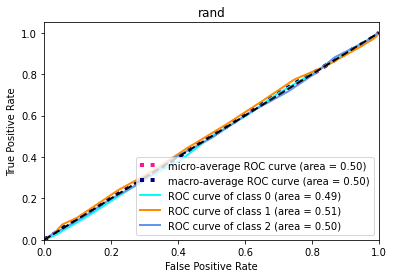

In [41]:
for method in ['real','rand']:
    print('Method', method)
    plot_roc_curve(probs_record[method]["probs_memory"], probs_record[method]["one_hot_y_test"], num_classes, method)

## Setting thresholds for non-informative signals

In [42]:
num_test_signal = len(probs_record[method]['pred_class'])

In [43]:
# set a lower limit because less than 25 signals creates weird artifacts
num_signals_vals = np.arange(25,num_test_signal,1)
num_signals_vals.shape

(2915,)

In [44]:
percent_discarded_signals = (1 - num_signals_vals/num_test_signal) * 100

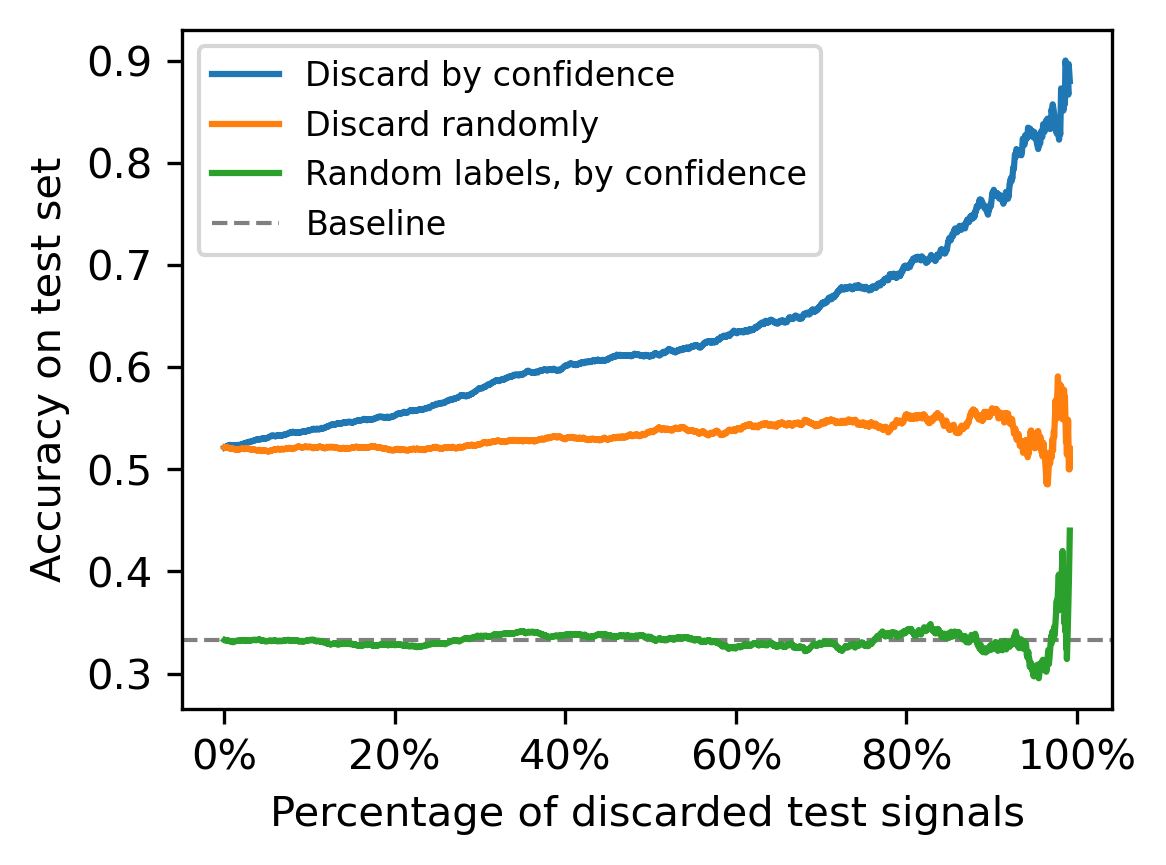

In [45]:
method = 'real'
acc_results, conf_thlds = accuracy_bysignumb_fixneigh(probs_record[method]['pred_class'], probs_record[method]['pred_conf'], probs_record[method]['true_class'], num_signals_vals, get_sigthld_conf=True)
acc_results_rand_discard, _ = accuracy_bysignumb_randomthld(probs_record[method]['pred_class'], probs_record[method]['pred_conf'], probs_record[method]['true_class'], num_signals_vals, get_sigthld_conf=True)
method = 'rand'
acc_results_rand_labels, _ = accuracy_bysignumb_fixneigh(probs_record[method]['pred_class'], probs_record[method]['pred_conf'], probs_record[method]['true_class'], num_signals_vals, get_sigthld_conf=True)

plt.figure(figsize=(4,3), dpi=300)
plt.axhline(0.3333, ls='--', lw=1, c='gray', label='Baseline')
plt.plot(percent_discarded_signals, acc_results, label='Discard by confidence')
plt.plot(percent_discarded_signals, acc_results_rand_discard, label='Discard randomly')
plt.plot(percent_discarded_signals, acc_results_rand_labels, label='Random labels, by confidence')
plt.xlabel('Percentage of discarded test signals')
plt.ylabel('Accuracy on test set')
plt.gca().xaxis.set_major_formatter(mtick.PercentFormatter(xmax=100))

handles, labels = plt.gca().get_legend_handles_labels()
order = [1,2,3,0]
#add legend to plot
plt.legend([handles[idx] for idx in order],[labels[idx] for idx in order],
          fontsize=8)
plt.savefig('../figs/knn4.kNNtest_info.png',dpi=300, bbox_inches='tight')
plt.show()

### Class imbalances when discarding non-informative signals

Method real


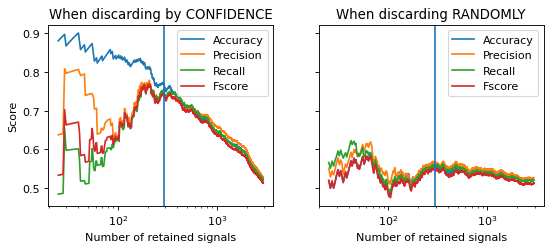

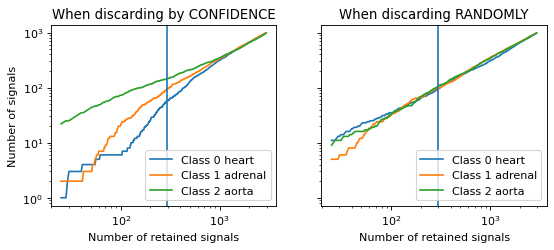

Method rand


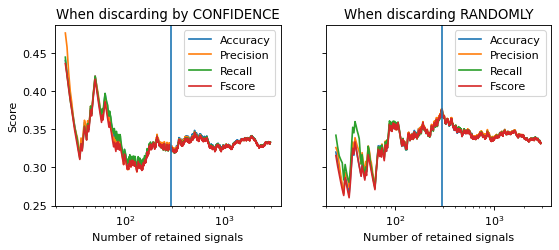

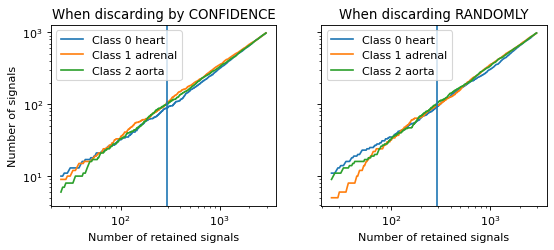

In [46]:
for method in ['real','rand']:
    print('Method', method)
    pred_class = probs_record[method]['pred_class']
    pred_conf = probs_record[method]['pred_conf']
    true_class = probs_record[method]['true_class']
    
    # discard by confidence 
    accuracy_bysignal = []
    precision_bysignal = []
    recall_bysignal = []
    fscore_bysignal = []
    numclass0_bysignal = []
    numclass1_bysignal = []
    numclass2_bysignal = []

    # indices to sort by decreasing order of confidences, maintaining dimensions
    sort_idx = np.argsort(pred_conf)[...,::-1]

    # sort both the predicted and true labels in decreasing order of confidence
    pred_sorted = np.take_along_axis(pred_class, sort_idx, axis=-1)
    true_sorted = np.take_along_axis(true_class, sort_idx, axis=-1)

    for num_sig in num_signals_vals:
        accuracy_bysignal.append(np.mean(pred_sorted[...,:num_sig] == true_sorted[...,:num_sig]))
        precision, recall, fscore, support = score(true_sorted[...,:num_sig], pred_sorted[...,:num_sig])
        precision_bysignal.append(np.mean(precision))
        recall_bysignal.append(np.mean(recall))
        fscore_bysignal.append(np.mean(fscore))
        numclass0_bysignal.append(support[0])
        numclass1_bysignal.append(support[1])
        numclass2_bysignal.append(support[2])
        
    # discard randomly
    accuracy_bysignal_rand = []
    precision_bysignal_rand = []
    recall_bysignal_rand = []
    fscore_bysignal_rand = []
    numclass0_bysignal_rand = []
    numclass1_bysignal_rand = []
    numclass2_bysignal_rand = []

    # indices to sort by decreasing order of confidences, maintaining dimensions
    sort_idx = np.arange(len(pred_conf))
    np.random.seed(42)
    np.random.shuffle(sort_idx)

    # sort both the predicted and true labels in decreasing order of confidence
    pred_sorted = np.take_along_axis(pred_class, sort_idx, axis=-1)
    true_sorted = np.take_along_axis(true_class, sort_idx, axis=-1)

    for num_sig in num_signals_vals:
        accuracy_bysignal_rand.append(np.mean(pred_sorted[...,:num_sig] == true_sorted[...,:num_sig]))
        precision, recall, fscore, support = score(true_sorted[...,:num_sig], pred_sorted[...,:num_sig])
        precision_bysignal_rand.append(np.mean(precision))
        recall_bysignal_rand.append(np.mean(recall))
        fscore_bysignal_rand.append(np.mean(fscore))
        numclass0_bysignal_rand.append(support[0])
        numclass1_bysignal_rand.append(support[1])
        numclass2_bysignal_rand.append(support[2])
    fig, axs = plt.subplots(1,2,figsize=(8,3), sharey=True, dpi=80)
    axs[0].plot(num_signals_vals, accuracy_bysignal, label='Accuracy')
    axs[0].plot(num_signals_vals, precision_bysignal, label='Precision')
    axs[0].plot(num_signals_vals, recall_bysignal, label='Recall')
    axs[0].plot(num_signals_vals, fscore_bysignal, label='Fscore')
    axs[1].plot(num_signals_vals, accuracy_bysignal_rand, label='Accuracy')
    axs[1].plot(num_signals_vals, precision_bysignal_rand, label='Precision')
    axs[1].plot(num_signals_vals, recall_bysignal_rand, label='Recall')
    axs[1].plot(num_signals_vals, fscore_bysignal_rand, label='Fscore')
    axs[0].set_title('When discarding by CONFIDENCE')
    axs[1].set_title('When discarding RANDOMLY')
    axs[0].set_xlabel('Number of retained signals')
    axs[1].set_xlabel('Number of retained signals')
    axs[0].axvline(294)
    axs[1].axvline(294)
    axs[0].set_ylabel('Score')
    axs[0].set_xscale('log')
    axs[1].set_xscale('log')
    axs[0].legend()
    axs[1].legend()
    plt.show()
    
    fig, axs = plt.subplots(1,2,figsize=(8,3), sharey=True, dpi=80)
    axs[0].plot(num_signals_vals, numclass0_bysignal, label=f'Class 0 {labels_key[0]}')
    axs[0].plot(num_signals_vals, numclass1_bysignal, label=f'Class 1 {labels_key[1]}')
    axs[0].plot(num_signals_vals, numclass2_bysignal, label=f'Class 2 {labels_key[2]}')
    axs[1].plot(num_signals_vals, numclass0_bysignal_rand, label=f'Class 0 {labels_key[0]}')
    axs[1].plot(num_signals_vals, numclass1_bysignal_rand, label=f'Class 1 {labels_key[1]}')
    axs[1].plot(num_signals_vals, numclass2_bysignal_rand, label=f'Class 2 {labels_key[2]}')
    axs[0].set_title('When discarding by CONFIDENCE')
    axs[1].set_title('When discarding RANDOMLY')
    axs[0].set_xlabel('Number of retained signals')
    axs[1].set_xlabel('Number of retained signals')
    axs[0].set_ylabel('Number of signals')
    axs[0].axvline(294)
    axs[1].axvline(294)
    axs[0].set_xscale('log')
    axs[1].set_xscale('log')
    axs[0].set_yscale('log')
    axs[1].set_yscale('log')
    axs[0].legend()
    axs[1].legend()
    plt.show()

### Accuracy results of limited dataset

Accuracy when discarding 90% of the signals

In [47]:
perc_discarding = 0.9

In [48]:
retained_signals = int(num_test_signal - (num_test_signal * 0.9))
print(retained_signals)

294


In [49]:
method = 'real'

In [50]:
accuracy, confidence_thld = accuracy_bysignumb_fixneigh(probs_record[method]['pred_class'], probs_record[method]['pred_conf'], probs_record[method]['true_class'], [retained_signals], get_sigthld_conf=True)

In [51]:
print(f'Accuracy on test set: {accuracy[0]}')

Accuracy on test set: 0.7653061224489796
